In [1]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import datatools
import datetime
import pvlib
import math
import statistics
import warnings
from math import sqrt


%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=1)

In [2]:
#identify module names 
mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar', 'Jinko'
#read in previously generated data
#input file names :       'temp_inputs_112021.csv' or 'temp_inputs_052021.csv'
inputs = pd.read_csv('temp_inputs_052021.csv', index_col='Unnamed: 0')
inputs.index = pd.to_datetime(inputs.index)
#this csv has temperature data organized horizontally instead of vertically for different types of analyses
mod_temps = pd.read_csv('modstrtemp_052021.csv')

In [3]:
#creating a df of system specific values
mod_data = {'LG': [18,1.686, 1.016, 24.229, 7.182, 45, 0.1871],
        'Panasonic': [18.5, 1.59, 1.053, 24.614, 7.878, 44, 0.1950],
        'Can270': [18.2, 1.65, 0.992, 31.088, 4.865, 45, 0.1706],
        'Can275': [18.2, 1.65, 0.992, 28.825, 4.452, 45, 0.1699],
        'HanQPlus': [18.8, 1.67, 1, 21.767, 6.585, 45,0.1676 ],
        'HanQPeak': [18.8, 1.67, 1, 30.536, 5.019, 45, 0.1864],
        'MissionSolar': [18.2, 1.664, 0.999, 22.678, 6.352, 44, 0.1881],
        'Jinko': [19, 1.65, 0.992, 27.308, 4.946, 45, 0.1720]}
# Creates pandas DataFrame.
mod_coeffs = pd.DataFrame(mod_data, index=['Mass', 'Length', 'Width', 'U0', 'U1', 'NOCT', 'eta'])
mod_coeffs

,LG,Panasonic,Can270,Can275,HanQPlus,HanQPeak,MissionSolar,Jinko
Mass,18.0000,18.500,18.2000,18.2000,18.8000,18.8000,18.2000,19.000
Length,1.6860,1.590,1.6500,1.6500,1.6700,1.6700,1.6640,1.650
Width,1.0160,1.053,0.9920,0.9920,1.0000,1.0000,0.9990,0.992
U0,24.2290,24.614,31.0880,28.8250,21.7670,30.5360,22.6780,27.308
U1,7.1820,7.878,4.8650,4.4520,6.5850,5.0190,6.3520,4.946
NOCT,45.0000,44.000,45.0000,45.0000,45.0000,45.0000,44.0000,45.000
eta,0.1871,0.195,0.1706,0.1699,0.1676,0.1864,0.1881,0.172


In [5]:
#Generate an empty df to store appended results
results = []

#Run all temperature models for all systems
for mod_name in mod_names:    

    module = mod_coeffs[mod_name]
    start = inputs.index[0]
    end = inputs.index[-1]
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

   
    # -----------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    
    mod_sapm = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b']).to_frame()    
    mod_sapm.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)

    mod_sapm['Model'] = 'SAPM'
    mod_sapm['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    mod_sapm['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    mod_sapm['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    mod_sapm['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    mod_sapm['TmStamp'] = mod_sapm.index
    mod_sapm['System'] = mod_name
    results.append(mod_sapm)
    #sapm with transient prilliman model applied
    mod_trans_sapm = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5])).to_frame()
    mod_trans_sapm.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    mod_trans_sapm['Model'] = 'SAPM - Transient'
    mod_trans_sapm['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    mod_trans_sapm['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    mod_trans_sapm['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    mod_trans_sapm['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    mod_trans_sapm['TmStamp'] = mod_trans_sapm.index
    mod_trans_sapm['System'] = mod_name
    results.append(mod_trans_sapm)
    #sapm_cell
    sapm_cell = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT']).to_frame()
    sapm_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    sapm_cell['Model'] = 'SAPM Cell'
    sapm_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    sapm_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    sapm_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    sapm_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    sapm_cell['TmStamp'] = sapm_cell.index
    sapm_cell['System'] = mod_name
    results.append(sapm_cell)
    # -----------------------------------------------------------------------------------------------------------------
    #ross cell
    ross_cell = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT']).to_frame()
    ross_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    ross_cell['Model'] = 'Ross Cell'
    ross_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    ross_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    ross_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    ross_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    ross_cell['TmStamp'] = ross_cell.index
    ross_cell['System'] = mod_name
    results.append(ross_cell)
    # -----------------------------------------------------------------------------------------------------------------
    #pvsyst cell
    pvsyst_cell = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    pvsyst_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    pvsyst_cell['Model'] = 'PVSyst Cell'
    pvsyst_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    pvsyst_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    pvsyst_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    pvsyst_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    pvsyst_cell['TmStamp'] = pvsyst_cell.index
    pvsyst_cell['System'] = mod_name
    results.append(pvsyst_cell)                     
    # -----------------------------------------------------------------------------------------------------------------
      #SAM NOCT
    sam_cell = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta']).to_frame()
    sam_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    sam_cell['Model'] = 'NOCT SAM'
    sam_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    sam_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    sam_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    sam_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    sam_cell['TmStamp'] = sam_cell.index
    sam_cell['System'] = mod_name
    results.append(sam_cell)
                               
    # -----------------------------------------------------------------------------------------------------------------
    #faiman
    temp_faiman = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1']).to_frame()
    temp_faiman.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    temp_faiman['Model']='Faiman'
    temp_faiman['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    temp_faiman['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    temp_faiman['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    temp_faiman['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    temp_faiman['TmStamp']=temp_faiman.index
    temp_faiman['System'] = mod_name
    results.append(temp_faiman)
    
    # -----------------------------------------------------------------------------------------------------------------
    #fuentes
    fuentes_temp = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length']).to_frame()
    fuentes_temp.rename(columns = {'tmod' : 'Modeled Temperature'}, inplace = True)
    fuentes_temp['Model']='Fuentes'
    fuentes_temp['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    fuentes_temp['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    fuentes_temp['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    fuentes_temp['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    fuentes_temp['TmStamp']=fuentes_temp.index
    fuentes_temp['System'] = mod_name
    results.append(fuentes_temp)
    
    # -----------------------------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------------------------
    del mod_inputs

In [6]:
#Concatenate all of the results from every system with every model
results = pd.concat(results, ignore_index=True)
results.index = results.TmStamp

## Visualizing Results for Each System

In [7]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'LG'
model1 = 'SAPM Cell'
model2 = 'Ross Cell'
model3 = 'PVSyst Cell'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4', 'JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)    

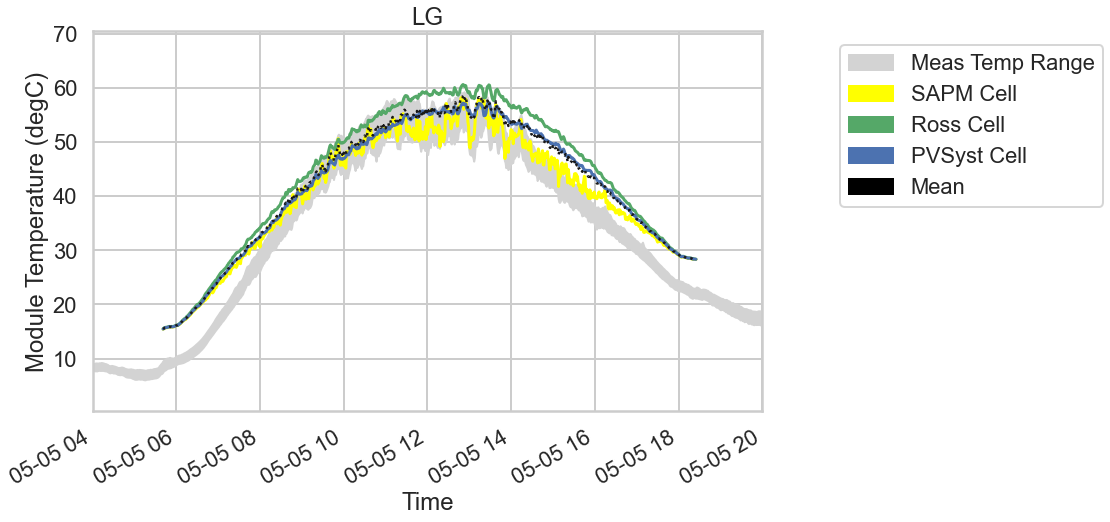

In [11]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim('2021-05-05 04:00:00-07:00','2021-05-05 20:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for LG System')

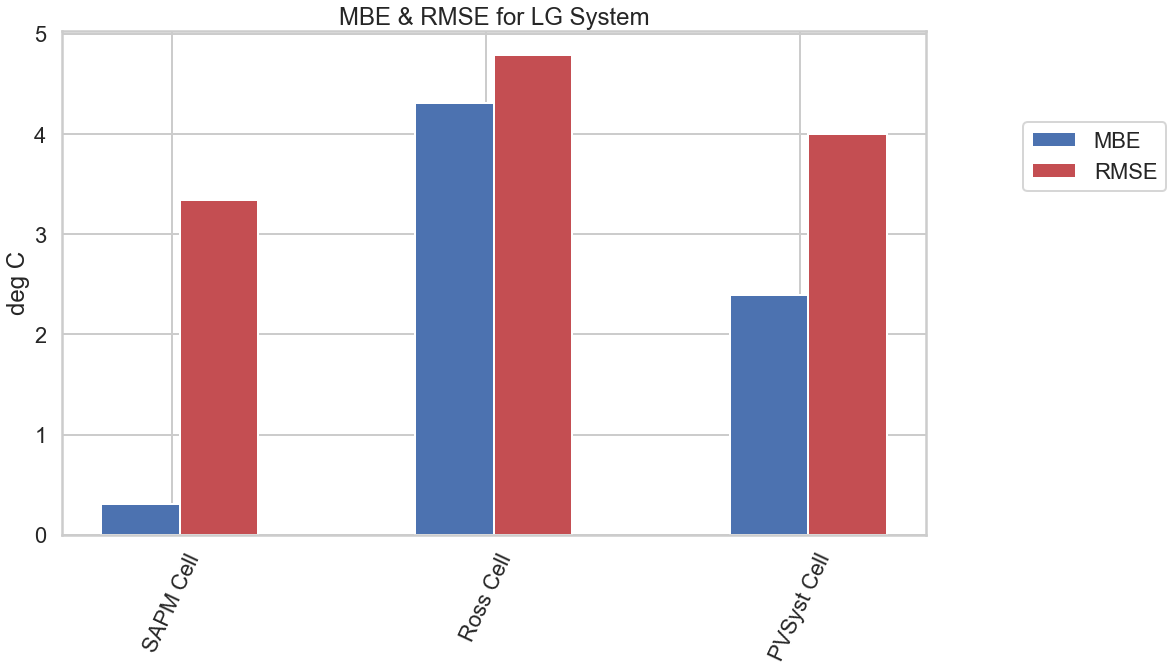

In [12]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### Panasonic System

In [13]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'Panasonic'
model1 = 'SAPM'
model2 = 'Faiman'
model3 = 'Fuentes'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

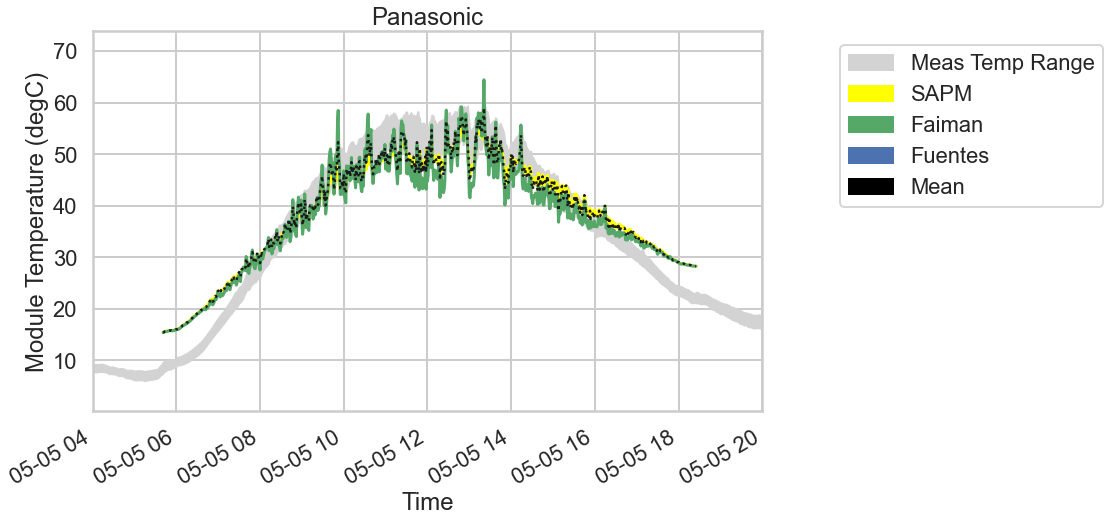

In [15]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim('2021-05-05 04:00:00-07:00','2021-05-05 20:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for Panasonic System')

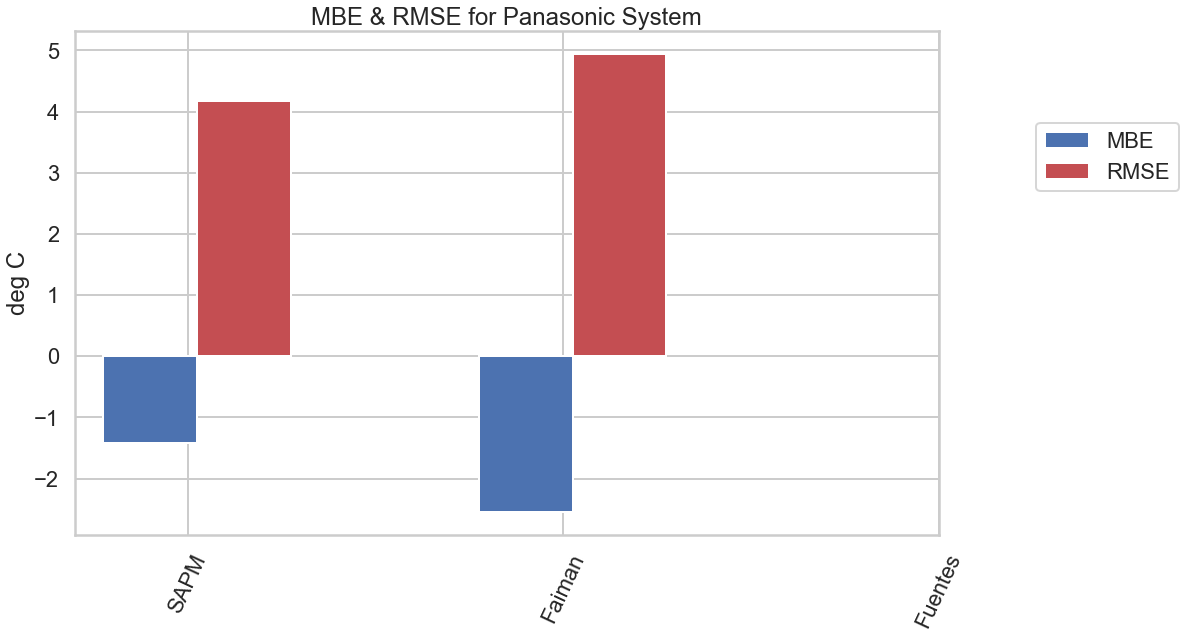

In [16]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### Can270 System

In [21]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'Can270'
model1 = 'NOCT SAM'
model2 = 'SAPM - Transient'
model3 = 'Faiman'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

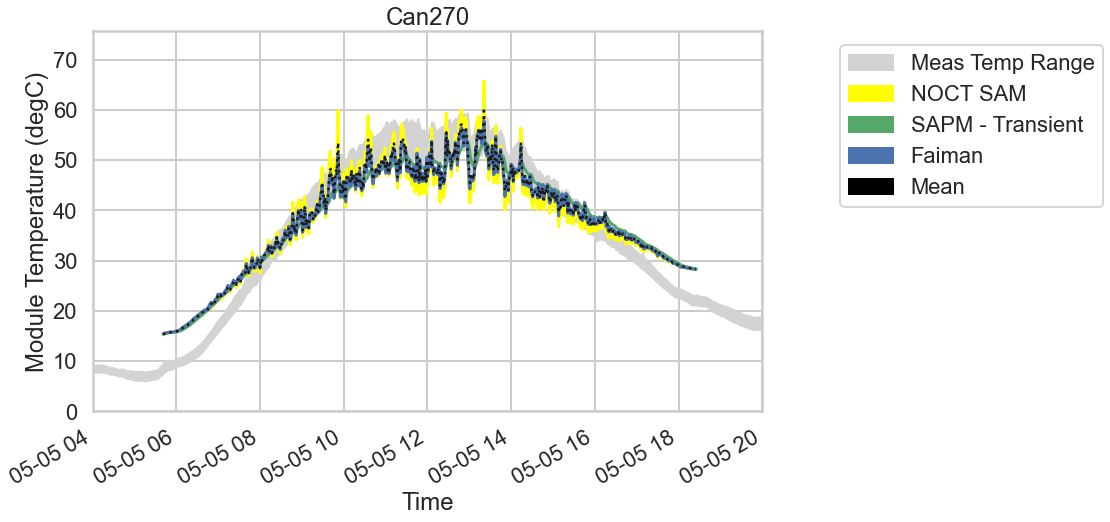

In [23]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim(x[6000], x[6960])
#plt.xlim('2021-11-01 04:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for Can270 System')

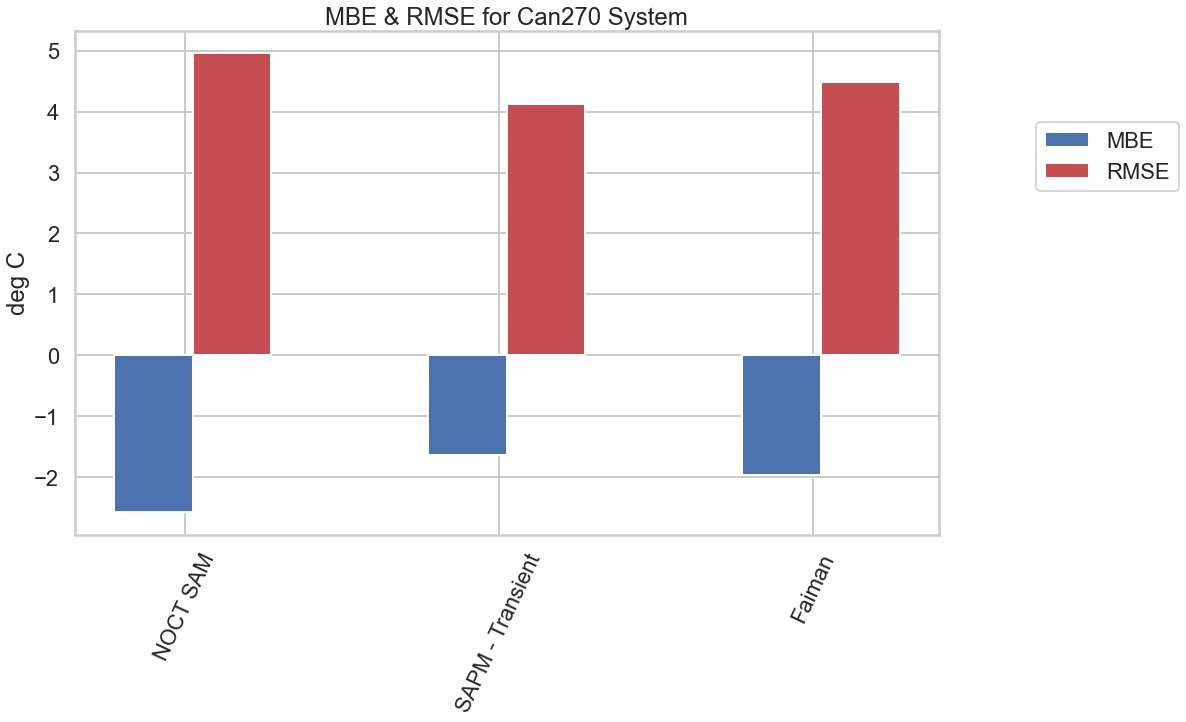

In [24]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### Can275 System

In [27]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'Can275'
model1 = 'SAPM'
model2 = 'Faiman'
model3 = 'Fuentes'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

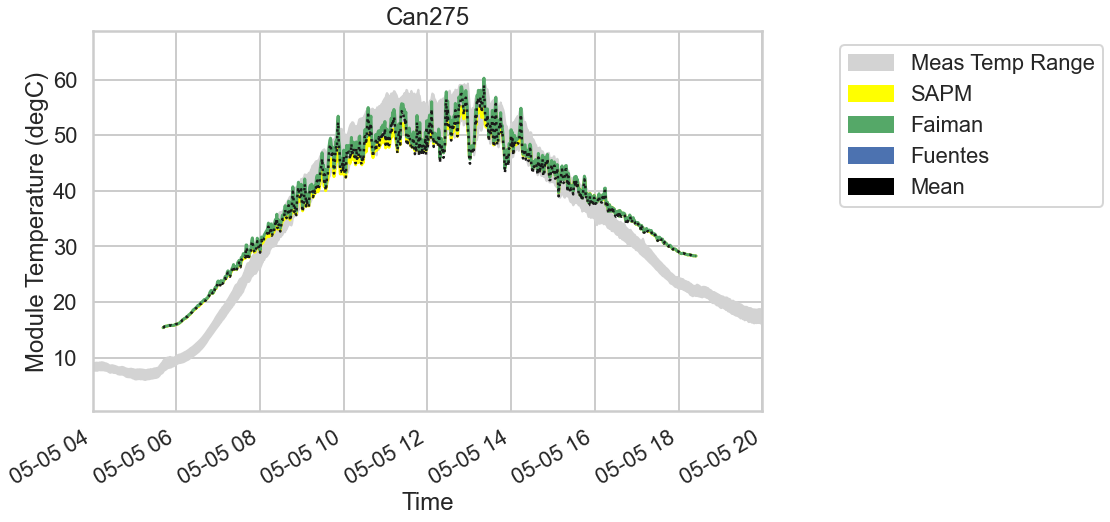

In [28]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim(x[6000], x[6960])
#plt.xlim('2021-11-01 04:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for Can275 System')

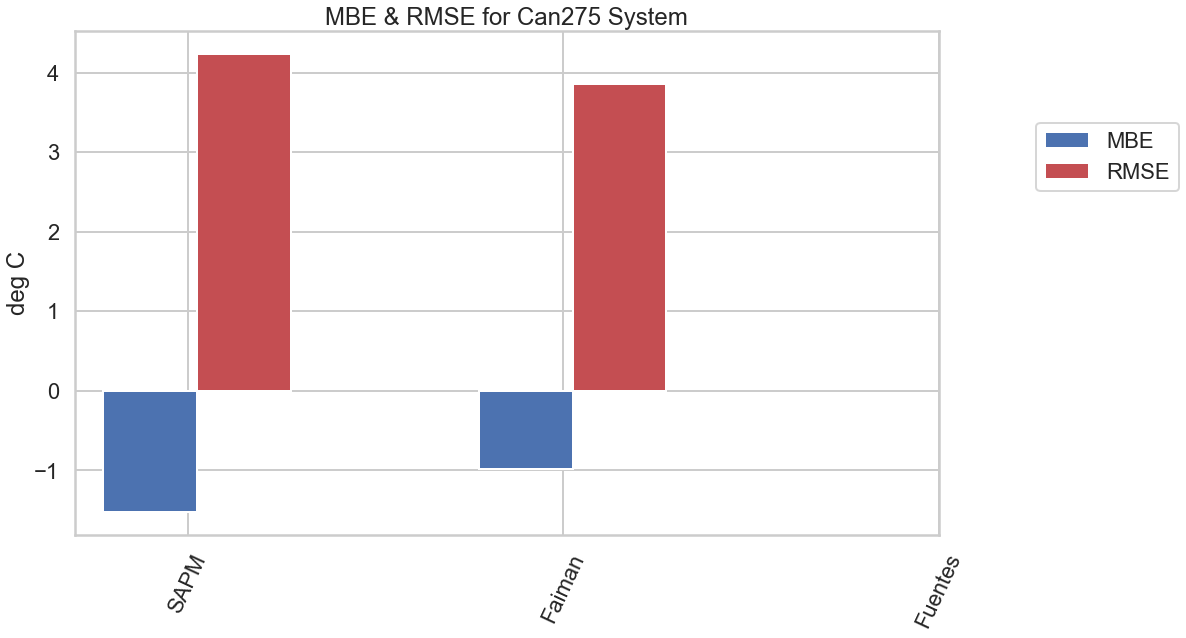

In [29]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### HanQPeak System

In [33]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'HanQPeak'
model1 = 'SAPM Cell'
model2 = 'NOCT SAM'
model3 = 'PVSyst Cell'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

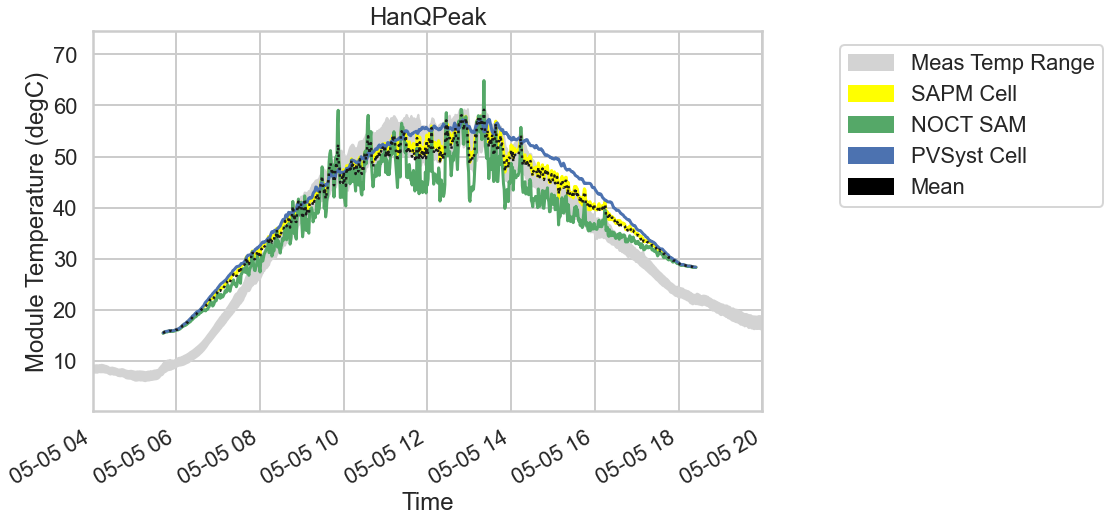

In [34]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim(x[6000], x[6960])
#plt.xlim('2021-11-01 04:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for HanQPeak System')

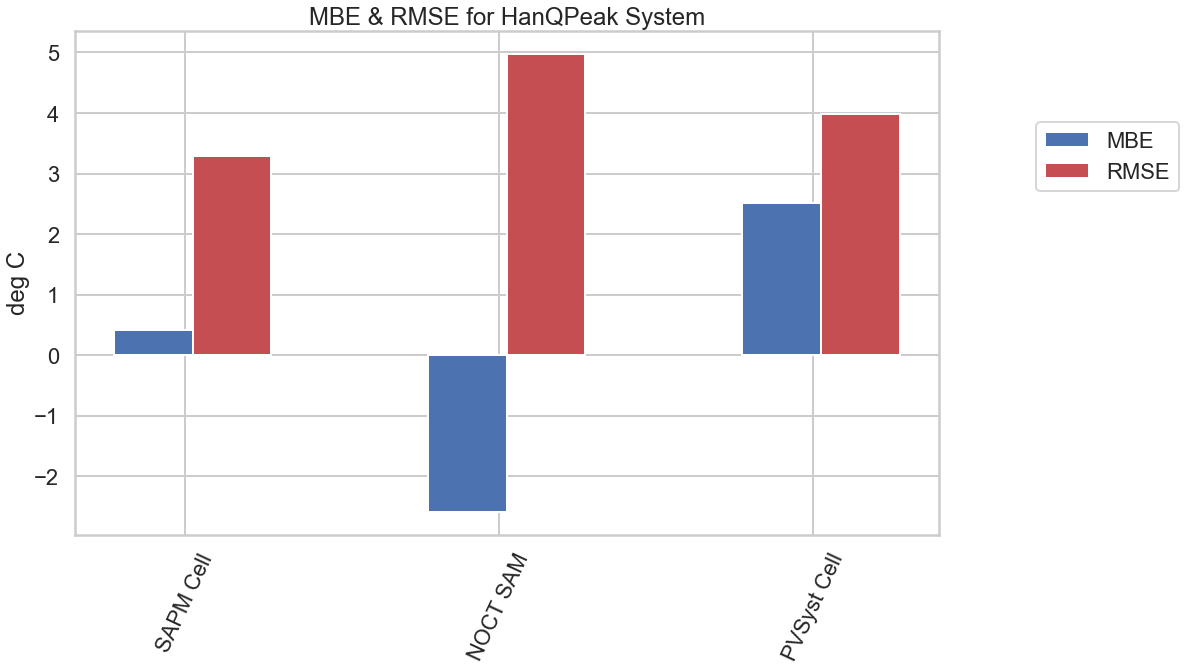

In [35]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### HanQPeak System

In [36]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'HanQPlus'
model1 = 'SAPM - Transient'
model2 = 'NOCT SAM'
model3 = 'Faiman'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

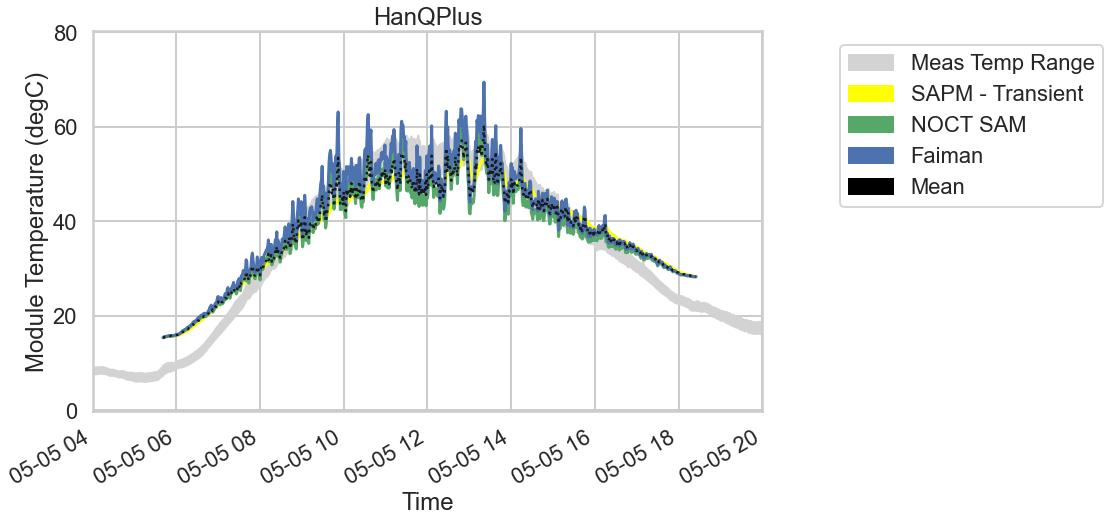

In [37]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim(x[6000], x[6960])
#plt.xlim('2021-11-01 04:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for HanQPlus System')

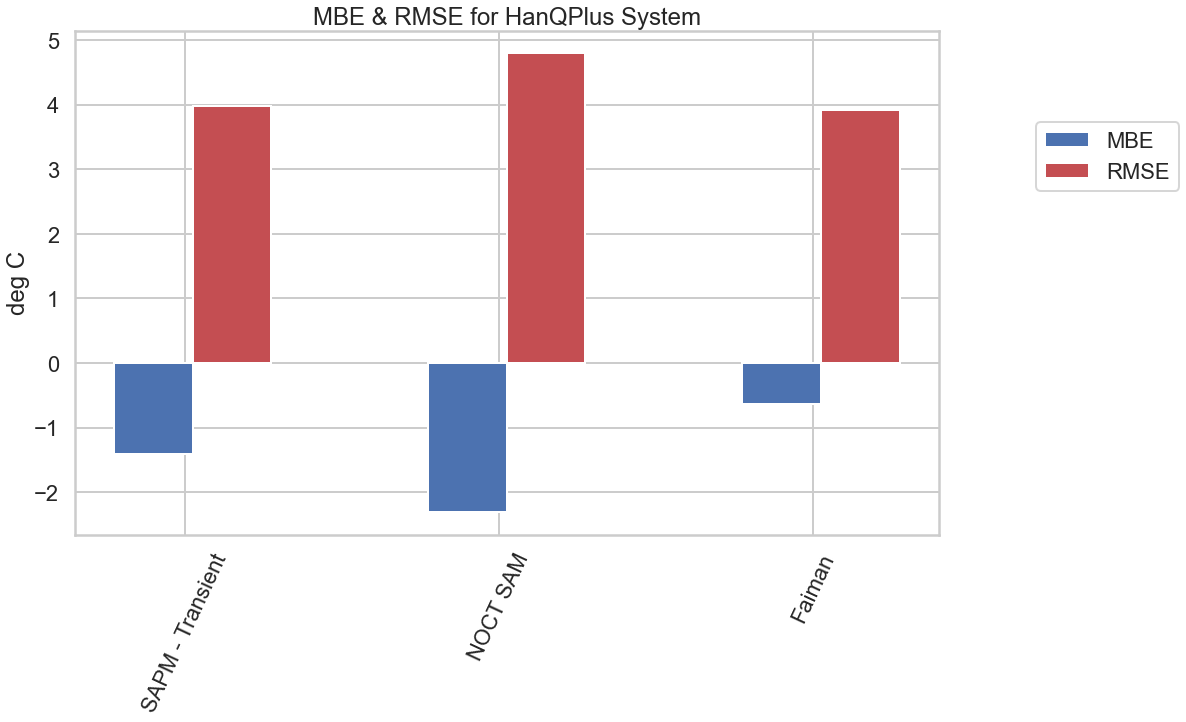

In [38]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### MissionSolar System

In [39]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'MissionSolar'
model1 = 'SAPM'
model2 = 'NOCT SAM'
model3 = 'Fuentes'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

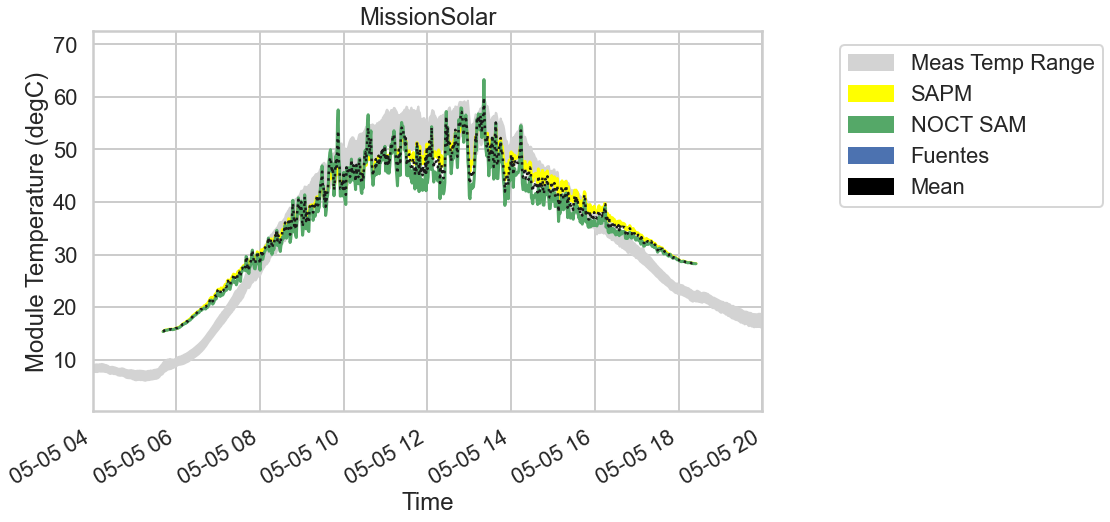

In [40]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim(x[6000], x[6960])
#plt.xlim('2021-11-01 04:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for MissionSolar System')

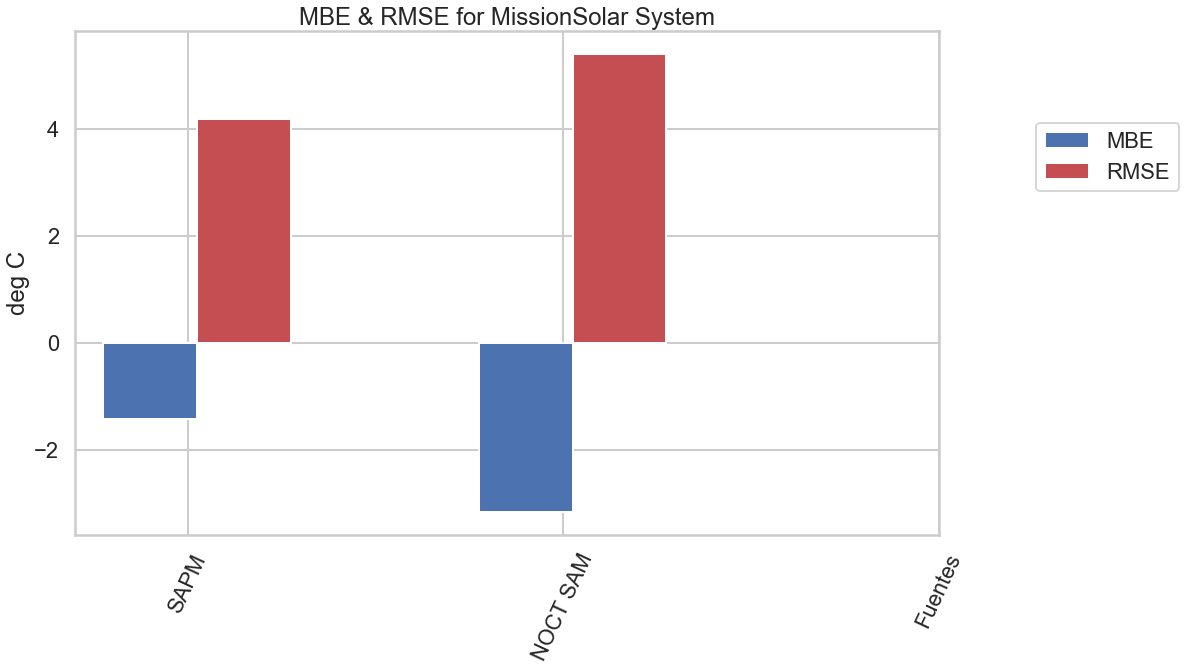

In [41]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')



#### Jinko System

In [44]:
#creating results horizontally to be able to take mean/median/min/max etc
######################################
#pick a system & 3 models to focus on
system = 'Jinko'
model1 = 'SAPM Cell'
model2 = 'Ross Cell'
model3 = 'PVSyst Cell'
#######################################
sysresults = results.loc[results['System']==system]
final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    
    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')
    # ---------------------------------------------------------------------------------------------------------------
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])
    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
    # ----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])
    # -----------------------------------------------------------------------------------------------------------------
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
    # -----------------------------------------------------------------------------------------------------------------
    
#find the minimum and maximum measured temperature at each timestep
mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4','JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)
#finding mean and median of models interested in plotting, can specify 3 below
final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

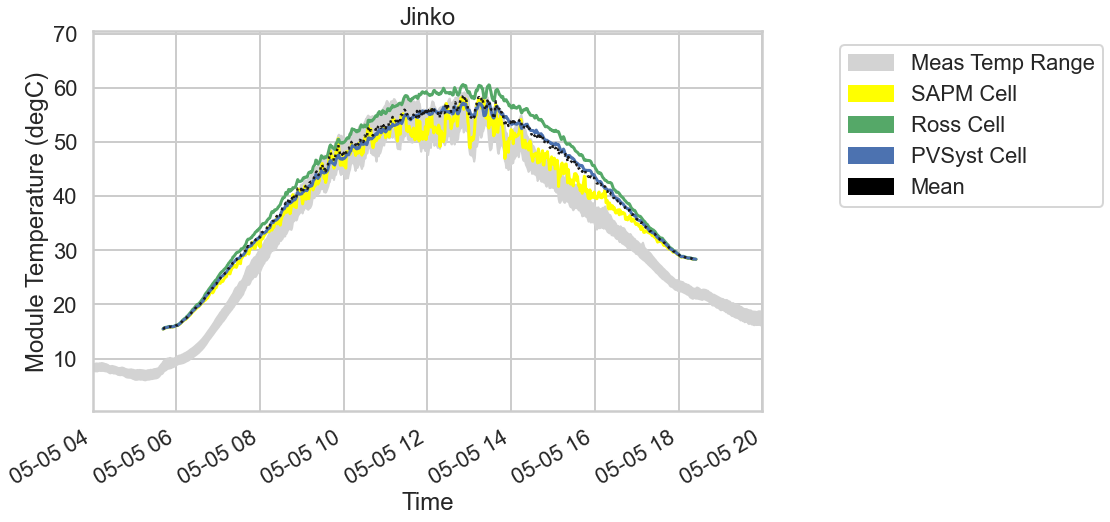

In [45]:
#this model is arbitrary, just need the TmStamp
x = sysresults.loc[sysresults['Model']=='SAPM']['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')
plt.xticks(rotation=30, ha='right')
y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)
plt.fill_between(x, lower, upper, color='lightgray')
plt.xlim(x[6000], x[6960])
#plt.xlim('2021-11-01 04:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)

# manually format legend
meas = mpatches.Patch(color='lightgrey', label='Meas Temp Range')
mdl1 = mpatches.Patch(color='yellow', label=model1)
mdl2 = mpatches.Patch(color='g', label=model2)
mdl3 = mpatches.Patch(color='b', label=model3)
means = mpatches.Patch(color='black', label='Mean')
handles = [meas,mdl1,mdl2,mdl3,means] 
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.75))

Text(0.5, 1.0, 'MBE & RMSE for Jinko System')

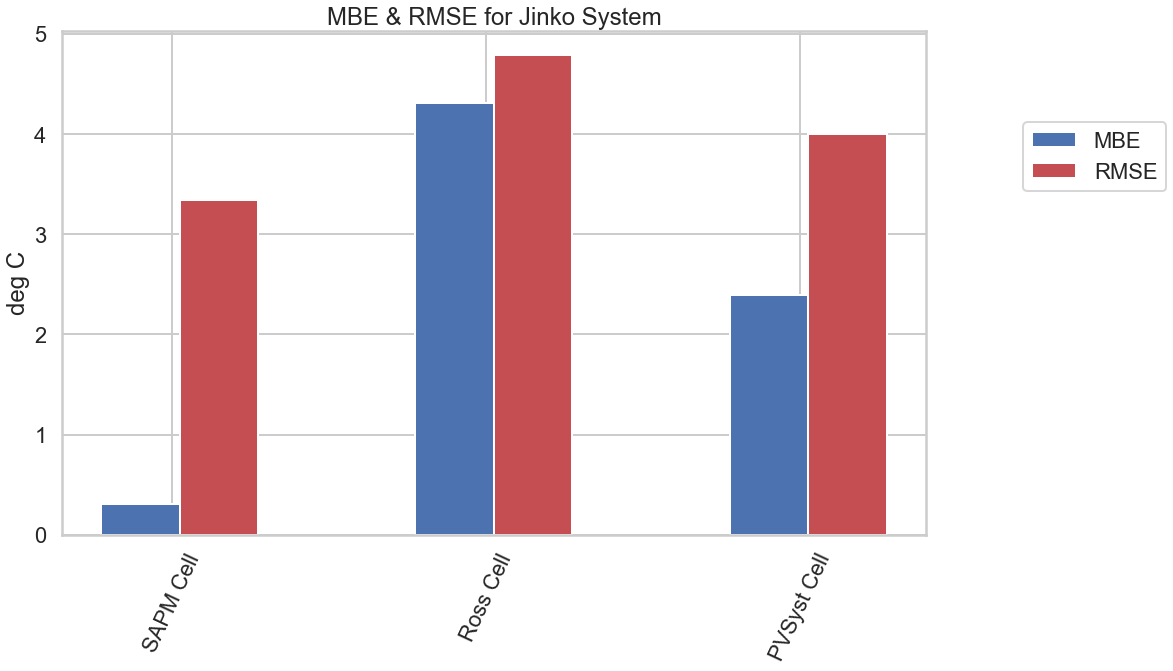

In [46]:
#Calculate mbe and rmse
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']
for string in strings:
       sysresults['Diff ' + string] = (sysresults['Modeled Temperature'] - sysresults[string]) 
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
#different systems have different number of strings available which affects the mbe/rmse calculations    
if system in all_rtd: 
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['MBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5

#formatting df of errors to make bar plot  
models = [model1,model2,model3]
errors = sysresults.loc[sysresults['Model']==model1].iloc[:,[-2,-1]].mean().to_frame().transpose()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model2].iloc[:,[-2,-1]].mean()
errors.loc[len(errors.index)] = sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean()
errors.rename(index={0:model1, 1:model2, 2:model3})

#plot mbe and rmse
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, errors['MBE'], color = 'b', width = 0.25)
ax.bar(X + 0.25, errors['RMSE'], color = 'r', width = 0.25)
#ax.bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2,-1]].mean(), color = 'b', width = 0.25)
ax.legend(['MBE', 'RMSE'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
ax.set_xticks([0.10, 1.10, 2.10])
ax.set_xticklabels([model1,model2,model3], rotation=65)
ax.set_ylabel('deg C')
ax.set_title('MBE & RMSE for '+system+' System')

